In [1]:
from __future__ import print_function, division

from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm


import copy
import os
import sys
import time

In [2]:
writer = SummaryWriter(log_dir='runs_efficientnet_b3_epoch1000')

In [3]:
data_dir = './data'
batch_size = 32
epoch = 1000
start_epoch = 100
input_size = 224

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

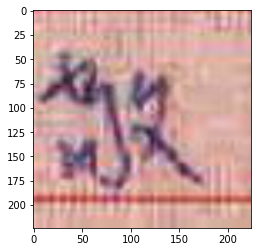

Label: 敬


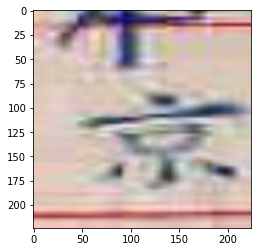

Label: 京


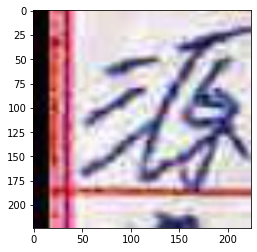

Label: 源


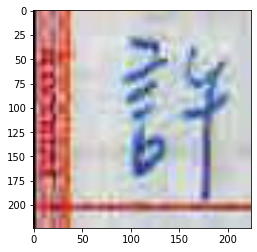

Label: 許


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

for i in range(4):
    imshow(inputs[i])
    print(f'Label: {class_names[classes[i]]}')

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            time_elapsed = time.time() - since
            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')
            
            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
                
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model_ft.state_dict(), './models/efficientnet-b3_epoch1000.pth')
                
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
    print(f'Best val Acc: {best_acc: 4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.close()
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print(f'Label: {class_names[labels[j]]} Predict: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_ft._fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft._fc  = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load('./models/efficientnet-b3_epoch100.pth'))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by cosine function, the first cycle is 5 epoches and the epoches of cycle will increase by multiply 2 after each cycle.
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=2)

Loaded pretrained weights for efficientnet-b3


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch)

  0%|          | 0/1627 [00:00<?, ?it/s]

Epoch 1/1000
----------


  0%|          | 0/407 [00:00<?, ?it/s]

train Loss:  0.0227 Acc:  0.9978


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3106 Acc:  0.9409

Epoch 2/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0231 Acc:  0.9974


100%|██████████| 407/407 [00:54<00:00,  7.49it/s]


val Loss:  0.3086 Acc:  0.9413


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 3/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.54it/s]

train Loss:  0.0214 Acc:  0.9979


100%|██████████| 407/407 [00:54<00:00,  7.50it/s]


val Loss:  0.3073 Acc:  0.9420


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 4/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.52it/s]

train Loss:  0.0213 Acc:  0.9978


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3099 Acc:  0.9413

Epoch 5/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0208 Acc:  0.9978


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3088 Acc:  0.9409

Epoch 6/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.58it/s]

train Loss:  0.0212 Acc:  0.9978


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3099 Acc:  0.9400

Epoch 7/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.01it/s]

train Loss:  0.0207 Acc:  0.9978


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9405

Epoch 8/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.50it/s]

train Loss:  0.0206 Acc:  0.9976


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3108 Acc:  0.9417

Epoch 9/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0200 Acc:  0.9979


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3119 Acc:  0.9414

Epoch 10/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.44it/s]

train Loss:  0.0192 Acc:  0.9982


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9413

Epoch 11/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.42it/s]

train Loss:  0.0193 Acc:  0.9980


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3096 Acc:  0.9417

Epoch 12/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0190 Acc:  0.9980


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3085 Acc:  0.9418

Epoch 13/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.57it/s]

train Loss:  0.0185 Acc:  0.9981


100%|██████████| 407/407 [00:55<00:00,  7.30it/s]


val Loss:  0.3089 Acc:  0.9421


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 14/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.10it/s]

train Loss:  0.0179 Acc:  0.9982


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3087 Acc:  0.9410

Epoch 15/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.29it/s]

train Loss:  0.0187 Acc:  0.9980


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3100 Acc:  0.9410

Epoch 16/1000
----------


  0%|          | 1/407 [00:00<00:58,  6.94it/s]

train Loss:  0.0184 Acc:  0.9980


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9417

Epoch 17/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.69it/s]

train Loss:  0.0183 Acc:  0.9983


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3138 Acc:  0.9410

Epoch 18/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.69it/s]

train Loss:  0.0178 Acc:  0.9982


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3128 Acc:  0.9404

Epoch 19/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0187 Acc:  0.9979


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3154 Acc:  0.9413

Epoch 20/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.42it/s]

train Loss:  0.0173 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9418

Epoch 21/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.66it/s]

train Loss:  0.0166 Acc:  0.9983


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3124 Acc:  0.9414

Epoch 22/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.58it/s]

train Loss:  0.0170 Acc:  0.9981


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3113 Acc:  0.9418

Epoch 23/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.40it/s]

train Loss:  0.0165 Acc:  0.9982


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3106 Acc:  0.9418

Epoch 24/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.52it/s]

train Loss:  0.0171 Acc:  0.9979


100%|██████████| 407/407 [00:55<00:00,  7.39it/s]


val Loss:  0.3124 Acc:  0.9423


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 25/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.13it/s]

train Loss:  0.0157 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9413

Epoch 26/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.44it/s]

train Loss:  0.0156 Acc:  0.9985


100%|██████████| 407/407 [00:54<00:00,  7.43it/s]


val Loss:  0.3113 Acc:  0.9425


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 27/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.40it/s]

train Loss:  0.0155 Acc:  0.9987


100%|██████████| 407/407 [00:55<00:00,  7.35it/s]


val Loss:  0.3093 Acc:  0.9434


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 28/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0149 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9427

Epoch 29/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0156 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3097 Acc:  0.9430

Epoch 30/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0147 Acc:  0.9983


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3102 Acc:  0.9430

Epoch 31/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0144 Acc:  0.9986


100%|██████████| 407/407 [00:55<00:00,  7.37it/s]


val Loss:  0.3109 Acc:  0.9435


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 32/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.28it/s]

train Loss:  0.0138 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3109 Acc:  0.9425

Epoch 33/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.69it/s]

train Loss:  0.0150 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3100 Acc:  0.9431

Epoch 34/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.41it/s]

train Loss:  0.0145 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3109 Acc:  0.9431

Epoch 35/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0140 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3100 Acc:  0.9430

Epoch 36/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.39it/s]

train Loss:  0.0150 Acc:  0.9987


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3119 Acc:  0.9421

Epoch 37/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0149 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3139 Acc:  0.9413

Epoch 38/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0147 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9420

Epoch 39/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.62it/s]

train Loss:  0.0147 Acc:  0.9985


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3125 Acc:  0.9419

Epoch 40/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.36it/s]

train Loss:  0.0154 Acc:  0.9982


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9425

Epoch 41/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.02it/s]

train Loss:  0.0140 Acc:  0.9987


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9428

Epoch 42/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.63it/s]

train Loss:  0.0146 Acc:  0.9983


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3140 Acc:  0.9418

Epoch 43/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0144 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3099 Acc:  0.9429

Epoch 44/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.39it/s]

train Loss:  0.0140 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3132 Acc:  0.9431

Epoch 45/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0134 Acc:  0.9986


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3130 Acc:  0.9429

Epoch 46/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0131 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3109 Acc:  0.9426

Epoch 47/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0125 Acc:  0.9988


100%|██████████| 407/407 [00:55<00:00,  7.39it/s]


val Loss:  0.3119 Acc:  0.9437


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 48/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.08it/s]

train Loss:  0.0128 Acc:  0.9987


100%|██████████| 407/407 [00:55<00:00,  7.30it/s]


val Loss:  0.3105 Acc:  0.9441


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 49/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.48it/s]

train Loss:  0.0122 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9427

Epoch 50/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.15it/s]

train Loss:  0.0131 Acc:  0.9984


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9440

Epoch 51/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0125 Acc:  0.9987


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3105 Acc:  0.9430

Epoch 52/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0127 Acc:  0.9985


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9427

Epoch 53/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.10it/s]

train Loss:  0.0117 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9433

Epoch 54/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.60it/s]

train Loss:  0.0121 Acc:  0.9987


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9435

Epoch 55/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.56it/s]

train Loss:  0.0119 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3098 Acc:  0.9436

Epoch 56/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.39it/s]

train Loss:  0.0115 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3098 Acc:  0.9432

Epoch 57/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.45it/s]

train Loss:  0.0118 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3095 Acc:  0.9433

Epoch 58/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0110 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9431

Epoch 59/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0112 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3101 Acc:  0.9438

Epoch 60/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.69it/s]

train Loss:  0.0110 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3102 Acc:  0.9438

Epoch 61/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.60it/s]

train Loss:  0.0107 Acc:  0.9991


100%|██████████| 407/407 [00:55<00:00,  7.38it/s]


val Loss:  0.3099 Acc:  0.9442


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 62/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.32it/s]

train Loss:  0.0107 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3087 Acc:  0.9441

Epoch 63/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.52it/s]

train Loss:  0.0108 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3089 Acc:  0.9438

Epoch 64/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.33it/s]

train Loss:  0.0103 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3093 Acc:  0.9439

Epoch 65/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.32it/s]

train Loss:  0.0107 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3094 Acc:  0.9440

Epoch 66/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.10it/s]

train Loss:  0.0106 Acc:  0.9991


100%|██████████| 407/407 [00:54<00:00,  7.40it/s]


val Loss:  0.3082 Acc:  0.9448


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 67/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.15it/s]

train Loss:  0.0107 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3092 Acc:  0.9445

Epoch 68/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.60it/s]

train Loss:  0.0105 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3094 Acc:  0.9443

Epoch 69/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0107 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3091 Acc:  0.9447

Epoch 70/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.08it/s]

train Loss:  0.0111 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3090 Acc:  0.9448

Epoch 71/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0109 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3107 Acc:  0.9445

Epoch 72/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.56it/s]

train Loss:  0.0105 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3097 Acc:  0.9443

Epoch 73/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.07it/s]

train Loss:  0.0105 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3098 Acc:  0.9441

Epoch 74/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0102 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3080 Acc:  0.9440

Epoch 75/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0107 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3094 Acc:  0.9443

Epoch 76/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.28it/s]

train Loss:  0.0106 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9440

Epoch 77/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0109 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3125 Acc:  0.9437

Epoch 78/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0110 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3127 Acc:  0.9440

Epoch 79/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.40it/s]

train Loss:  0.0110 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3121 Acc:  0.9445

Epoch 80/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.48it/s]

train Loss:  0.0109 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3127 Acc:  0.9435

Epoch 81/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0116 Acc:  0.9987


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3123 Acc:  0.9438

Epoch 82/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.50it/s]

train Loss:  0.0110 Acc:  0.9988


100%|██████████| 407/407 [00:54<00:00,  7.43it/s]


val Loss:  0.3103 Acc:  0.9453


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 83/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.06it/s]

train Loss:  0.0101 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9447

Epoch 84/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.61it/s]

train Loss:  0.0112 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9453

Epoch 85/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0107 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3076 Acc:  0.9453

Epoch 86/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0104 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3124 Acc:  0.9440

Epoch 87/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.10it/s]

train Loss:  0.0099 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9447

Epoch 88/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0098 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9450

Epoch 89/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.34it/s]

train Loss:  0.0101 Acc:  0.9990


100%|██████████| 407/407 [00:54<00:00,  7.45it/s]


val Loss:  0.3120 Acc:  0.9457


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 90/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0094 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3131 Acc:  0.9445

Epoch 91/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0092 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9443

Epoch 92/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0097 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3105 Acc:  0.9450

Epoch 93/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.66it/s]

train Loss:  0.0096 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3117 Acc:  0.9441

Epoch 94/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.48it/s]

train Loss:  0.0098 Acc:  0.9988


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3146 Acc:  0.9448

Epoch 95/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0096 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3139 Acc:  0.9447

Epoch 96/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.54it/s]

train Loss:  0.0089 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9456

Epoch 97/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.22it/s]

train Loss:  0.0089 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3119 Acc:  0.9456

Epoch 98/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.66it/s]

train Loss:  0.0088 Acc:  0.9990


100%|██████████| 407/407 [00:54<00:00,  7.46it/s]


val Loss:  0.3114 Acc:  0.9457


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 99/1000
----------


  0%|          | 1/407 [00:00<01:01,  6.56it/s]

train Loss:  0.0087 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3131 Acc:  0.9450

Epoch 100/1000
----------


  0%|          | 1/407 [00:00<01:00,  6.70it/s]

train Loss:  0.0090 Acc:  0.9990


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3123 Acc:  0.9456

Epoch 101/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.66it/s]

train Loss:  0.0085 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3135 Acc:  0.9450

Epoch 102/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.53it/s]

train Loss:  0.0089 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9452

Epoch 103/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.43it/s]

train Loss:  0.0087 Acc:  0.9991


100%|██████████| 407/407 [00:55<00:00,  7.40it/s]


val Loss:  0.3113 Acc:  0.9460


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 104/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.26it/s]

train Loss:  0.0089 Acc:  0.9989


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9441

Epoch 105/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.66it/s]

train Loss:  0.0082 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9456

Epoch 106/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.35it/s]

train Loss:  0.0079 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3130 Acc:  0.9449

Epoch 107/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0079 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3132 Acc:  0.9448

Epoch 108/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.04it/s]

train Loss:  0.0081 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3127 Acc:  0.9445

Epoch 109/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.37it/s]

train Loss:  0.0081 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3099 Acc:  0.9458

Epoch 110/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.17it/s]

train Loss:  0.0079 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3126 Acc:  0.9453

Epoch 111/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.43it/s]

train Loss:  0.0080 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9456

Epoch 112/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0077 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3145 Acc:  0.9456

Epoch 113/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.41it/s]

train Loss:  0.0080 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3128 Acc:  0.9441

Epoch 114/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.44it/s]

train Loss:  0.0076 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9457

Epoch 115/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0074 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9452

Epoch 116/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.23it/s]

train Loss:  0.0076 Acc:  0.9991


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3132 Acc:  0.9450

Epoch 117/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0074 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3125 Acc:  0.9453

Epoch 118/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.27it/s]

train Loss:  0.0073 Acc:  0.9993


100%|██████████| 407/407 [00:55<00:00,  7.38it/s]


val Loss:  0.3135 Acc:  0.9462


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 119/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.15it/s]

train Loss:  0.0072 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3129 Acc:  0.9453

Epoch 120/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0075 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3112 Acc:  0.9453

Epoch 121/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.35it/s]

train Loss:  0.0068 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3105 Acc:  0.9461

Epoch 122/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.71it/s]

train Loss:  0.0070 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9455

Epoch 123/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.17it/s]

train Loss:  0.0073 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9451

Epoch 124/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0068 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3128 Acc:  0.9447

Epoch 125/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.05it/s]

train Loss:  0.0069 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3113 Acc:  0.9453

Epoch 126/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.57it/s]

train Loss:  0.0068 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3119 Acc:  0.9452

Epoch 127/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.51it/s]

train Loss:  0.0071 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9450

Epoch 128/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.55it/s]

train Loss:  0.0072 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9452

Epoch 129/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.44it/s]

train Loss:  0.0070 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9450

Epoch 130/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0073 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3113 Acc:  0.9457

Epoch 131/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.14it/s]

train Loss:  0.0066 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3124 Acc:  0.9458

Epoch 132/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.63it/s]

train Loss:  0.0066 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3118 Acc:  0.9458

Epoch 133/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0066 Acc:  0.9994


100%|██████████| 407/407 [00:54<00:00,  7.40it/s]


val Loss:  0.3121 Acc:  0.9464


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 134/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.70it/s]

train Loss:  0.0064 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3135 Acc:  0.9458

Epoch 135/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.62it/s]

train Loss:  0.0069 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3126 Acc:  0.9457

Epoch 136/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0067 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3109 Acc:  0.9459

Epoch 137/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.71it/s]

train Loss:  0.0069 Acc:  0.9993


100%|██████████| 407/407 [00:54<00:00,  7.44it/s]


val Loss:  0.3122 Acc:  0.9467


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 138/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0066 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3111 Acc:  0.9456

Epoch 139/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0066 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3117 Acc:  0.9456

Epoch 140/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0069 Acc:  0.9993


100%|██████████| 407/407 [00:54<00:00,  7.44it/s]


val Loss:  0.3111 Acc:  0.9470


  0%|          | 0/1627 [00:00<?, ?it/s]


Epoch 141/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.34it/s]

train Loss:  0.0064 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9459

Epoch 142/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.52it/s]

train Loss:  0.0063 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3120 Acc:  0.9462

Epoch 143/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0070 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9460

Epoch 144/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0069 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3122 Acc:  0.9463

Epoch 145/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0066 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9461

Epoch 146/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.26it/s]

train Loss:  0.0070 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9457

Epoch 147/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.55it/s]

train Loss:  0.0062 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3115 Acc:  0.9456

Epoch 148/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.40it/s]

train Loss:  0.0070 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3108 Acc:  0.9456

Epoch 149/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0067 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3127 Acc:  0.9459

Epoch 150/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.37it/s]

train Loss:  0.0067 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3121 Acc:  0.9459

Epoch 151/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.34it/s]

train Loss:  0.0068 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3117 Acc:  0.9460

Epoch 152/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0064 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3107 Acc:  0.9462

Epoch 153/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.42it/s]

train Loss:  0.0061 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3119 Acc:  0.9460

Epoch 154/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.16it/s]

train Loss:  0.0068 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3114 Acc:  0.9458

Epoch 155/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.46it/s]

train Loss:  0.0065 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3116 Acc:  0.9456

Epoch 156/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.60it/s]

train Loss:  0.0060 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3129 Acc:  0.9460

Epoch 157/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.44it/s]

train Loss:  0.0067 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3143 Acc:  0.9462

Epoch 158/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0074 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3176 Acc:  0.9454

Epoch 159/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.38it/s]

train Loss:  0.0063 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3194 Acc:  0.9463

Epoch 160/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.57it/s]

train Loss:  0.0073 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3145 Acc:  0.9455

Epoch 161/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.53it/s]

train Loss:  0.0068 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3153 Acc:  0.9465

Epoch 162/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.35it/s]

train Loss:  0.0067 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3151 Acc:  0.9456

Epoch 163/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0071 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3155 Acc:  0.9446

Epoch 164/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.34it/s]

train Loss:  0.0068 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3178 Acc:  0.9443

Epoch 165/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.04it/s]

train Loss:  0.0066 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3170 Acc:  0.9446

Epoch 166/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.13it/s]

train Loss:  0.0064 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3191 Acc:  0.9450

Epoch 167/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0069 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3171 Acc:  0.9453

Epoch 168/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0065 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3161 Acc:  0.9460

Epoch 169/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0063 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3168 Acc:  0.9461

Epoch 170/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.33it/s]

train Loss:  0.0068 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3180 Acc:  0.9453

Epoch 171/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.61it/s]

train Loss:  0.0066 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3162 Acc:  0.9454

Epoch 172/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.28it/s]

train Loss:  0.0061 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3143 Acc:  0.9460

Epoch 173/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.49it/s]

train Loss:  0.0065 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3151 Acc:  0.9453

Epoch 174/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.08it/s]

train Loss:  0.0063 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3141 Acc:  0.9460

Epoch 175/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0063 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3174 Acc:  0.9449

Epoch 176/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0062 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3152 Acc:  0.9453

Epoch 177/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.65it/s]

train Loss:  0.0066 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3166 Acc:  0.9447

Epoch 178/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0065 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3164 Acc:  0.9451

Epoch 179/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.11it/s]

train Loss:  0.0064 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3169 Acc:  0.9450

Epoch 180/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.31it/s]

train Loss:  0.0062 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3176 Acc:  0.9464

Epoch 181/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.29it/s]

train Loss:  0.0062 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3169 Acc:  0.9461

Epoch 182/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.29it/s]

train Loss:  0.0057 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3172 Acc:  0.9451

Epoch 183/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.69it/s]

train Loss:  0.0061 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3178 Acc:  0.9457

Epoch 184/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.58it/s]

train Loss:  0.0059 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3180 Acc:  0.9467

Epoch 185/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0060 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3182 Acc:  0.9457

Epoch 186/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.30it/s]

train Loss:  0.0063 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3207 Acc:  0.9463

Epoch 187/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.68it/s]

train Loss:  0.0061 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3199 Acc:  0.9465

Epoch 188/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.36it/s]

train Loss:  0.0057 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3187 Acc:  0.9461

Epoch 189/1000
----------


  0%|          | 1/407 [00:00<00:55,  7.29it/s]

train Loss:  0.0056 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3182 Acc:  0.9469

Epoch 190/1000
----------


  0%|          | 1/407 [00:00<00:56,  7.23it/s]

train Loss:  0.0060 Acc:  0.9992


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3196 Acc:  0.9453

Epoch 191/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.53it/s]

train Loss:  0.0054 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3199 Acc:  0.9459

Epoch 192/1000
----------


  0%|          | 1/407 [00:00<00:53,  7.64it/s]

train Loss:  0.0058 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3194 Acc:  0.9451

Epoch 193/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.41it/s]

train Loss:  0.0053 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3197 Acc:  0.9448

Epoch 194/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.50it/s]

train Loss:  0.0054 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3203 Acc:  0.9452

Epoch 195/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.39it/s]

train Loss:  0.0057 Acc:  0.9993


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3215 Acc:  0.9453

Epoch 196/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.39it/s]

train Loss:  0.0058 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3181 Acc:  0.9469

Epoch 197/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.50it/s]

train Loss:  0.0059 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3168 Acc:  0.9465

Epoch 198/1000
----------


  0%|          | 1/407 [00:00<00:57,  7.03it/s]

train Loss:  0.0051 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3192 Acc:  0.9465

Epoch 199/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.40it/s]

train Loss:  0.0054 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3220 Acc:  0.9467

Epoch 200/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0054 Acc:  0.9996


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3221 Acc:  0.9457

Epoch 201/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.67it/s]

train Loss:  0.0053 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3223 Acc:  0.9461

Epoch 202/1000
----------


  0%|          | 1/407 [00:00<00:52,  7.71it/s]

train Loss:  0.0051 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3204 Acc:  0.9459

Epoch 203/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0054 Acc:  0.9995


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3202 Acc:  0.9467

Epoch 204/1000
----------


  0%|          | 1/407 [00:00<00:54,  7.47it/s]

train Loss:  0.0052 Acc:  0.9994


  0%|          | 0/1627 [00:00<?, ?it/s]

val Loss:  0.3197 Acc:  0.9468

Epoch 205/1000
----------


 29%|██▉       | 470/1627 [03:00<07:20,  2.63it/s]

In [ ]:
visualize_model(model_ft)

In [ ]:
from PIL import Image

def inference_model(model, input_image_path):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        with Image.open(input_image_path) as input_image:
            resized_image = data_transforms['val'](input_image).unsqueeze(0).to(device)
            label = input_image_path.split('_')[-1].split('.')[0]
            
            output = model(resized_image)
            _, pred = torch.max(output, 1)
            
        model.train(mode=was_training)
    
    return class_names[pred[0]], label

In [ ]:
import matplotlib.image as mpimg

fig = plt.figure()

since = time.time()

words = ['2530_田.jpg', '22972_千.jpg', '35749_田.jpg', '38828_昇.jpg', '57332_主.jpg']

for i, word in enumerate(words):
    start = time.time()
    pred, label = inference_model(model_ft, os.path.join('./data/all/', word))
    print(f'Image {i + 1}\nPredict: {pred}, Label: {label}, Time elapsed: {time.time() - start}\n')
    img = mpimg.imread(os.path.join('./data/all', word))
    plt.imshow(img)
    plt.pause(0.001)
    
time_elapsed = time.time() - since

print(f'Inference Time: {time_elapsed / len(words)}')

In [ ]:
model_test = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model_test._fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_test._fc  = nn.Linear(num_ftrs, len(class_names))

model_test.to(device)

model_test.load_state_dict(torch.load('./models/efficientnet-b7.pth'))
model_test.eval()

In [ ]:
import matplotlib.image as mpimg

fig = plt.figure()

since = time.time()

words = ['2530_田.jpg', '22972_千.jpg', '35749_田.jpg', '38828_昇.jpg', '57332_主.jpg']

for i, word in enumerate(words):
    start = time.time()
    pred, label = inference_model(model_test, os.path.join('./data/all/', word))
    print(f'Image {i + 1}\nPredict: {pred}, Label: {label}, Time elapsed: {time.time() - start}\n')
    img = mpimg.imread(os.path.join('./data/all', word))
    plt.imshow(img)
    plt.pause(0.001)
    
time_elapsed = time.time() - since

print(f'Inference Time: {time_elapsed / len(words)}')